# Timing figures
This notebook is a test bed to plot some of the figures henry has requested, in preparation for beam-on data!

In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
import glob
import pickle as pkl

In [2]:
features = ['run', 'subrun', 'event', 'feb_mac5', 'feb_tagger', 'feb_flags',
       'feb_ts0', 'feb_ts1', 'feb_unixs', 'feb_adc', 'feb_coinc', 'cl_ts0',
       'cl_ts1', 'cl_unixs', 'cl_nhits', 'cl_tagger', 'cl_composition',
       'cl_channel_set', 'cl_adc_set', 'cl_has_sp', 'cl_sp_x', 'cl_sp_ex',
       'cl_sp_y', 'cl_sp_ey', 'cl_sp_z', 'cl_sp_ez', 'cl_sp_pe', 'cl_sp_ts0',
       'cl_sp_ets0', 'cl_sp_ts1', 'cl_sp_ets1', 'cl_sp_complete', 'tr_start_x',
       'tr_start_y', 'tr_start_z', 'tr_end_x', 'tr_end_y', 'tr_end_z',
      'tdc_channel', 'tdc_timestamp', 'tdc_offset',
       'tdc_name']

CRT_Wall_Dict = {
       "South": 1,
       "North": 2,
       "West": 3,
       "East": 4,
       "Bottom": 0,
       "Top Low": 5,
       "Top High": 6
       }

CRT_Wall_Arr = ["Bottom", "South", "North", "West", "East", "Top Low", "Top High"]

In [4]:
def list_matching_files(folder_path, pattern):
    search_pattern = os.path.join(folder_path, pattern)
    files = glob.glob(search_pattern)
    return [f for f in files if os.path.isfile(f)]

# path = "/exp/sbnd/data/users/jbateman/workdir/crt/run/"
path ="/pnfs/sbnd/persistent/users/jbateman/crt/run/"
run="017985" # [017985, 017987, 018019]
# run="017985"
folder_path = path+run

# matching_files = list_matching_files(folder_path, "crtana_data_*")
matching_files = list_matching_files(folder_path, "crt_ana_*")

# Check how many files there are - memory gets upset if you try load too many
# Splitting the files into batches of 3 for now
batch_number = 0
batch_size = 50
# Theres probably a better way to loop this, but this is good enough for now!
print("Total batches = ", int(np.ceil(len(matching_files)/batch_size)))
matching_files = matching_files[batch_number*batch_size:(batch_number+1)*batch_size]

save = False # Decide whether to save the data to a pkl for later. If unsure, leave False

Total batches =  4


In [5]:
features = ["feb_ts0", "feb_ts1", "feb_flags", "tdc_timestamp", "tdc_name", "cl_has_sp", "cl_tagger", "cl_sp_ts0", "cl_sp_ts1", "cl_sp_x","cl_sp_y", "cl_sp_z"]

# Load the first file to get the columns
ttree = uproot.open(matching_files[0])
print("Loading ", matching_files[0], "...")

recodata = ttree['crtana/tree'].arrays(features, library='ak')
# recodata = ttree['crtana/tree'].arrays(library='ak')

# Merge all the files into one dataframe (now an awkward array, which speeds everything up so much)
for file in matching_files[1:]:
    print("Loading ", file, "...")
    ttree = uproot.open(file)

    temp_recodata = ttree['crtana/tree'].arrays(features, library='ak')
    # temp_recodata = ttree['crtana/tree'].arrays(library='ak')

    recodata = ak.concatenate([recodata, temp_recodata])
    ttree.close()


Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_aa.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ab.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ac.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ad.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ae.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_af.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ag.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ah.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ai.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_aj.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ak.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_al.root ...
Loading  /pnfs/sbnd/persiste

### Plotting the flag 3/ts1 an alternative way (no use of TDC etrig)

Text(0.5, 0, '(feb_ts1 | Flag == 3) (ms)')

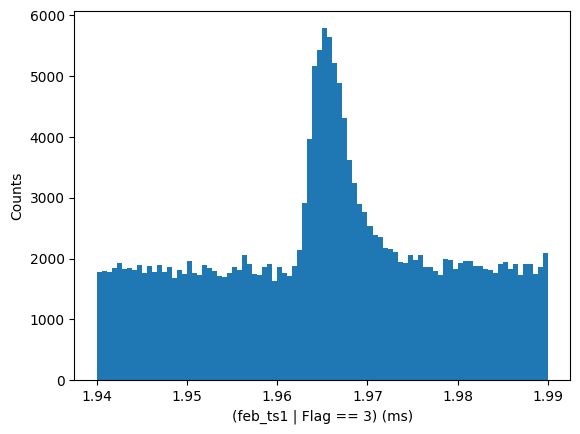

In [6]:
filter_ts0 = recodata["feb_ts0"][recodata.feb_flags == 3] 
filter_ts1 = recodata["feb_ts1"][recodata.feb_flags == 3]

plt.hist(ak.flatten(filter_ts1)/1e6, range=(1.94,1.99), bins = 90)
# plt.yscale('log')
plt.title('')
plt.ylabel('Counts')
plt.xlabel('(feb_ts1 | Flag == 3) (ms)')

Checking the reset time range for run 18019 (which was changed in error)

Text(0.5, 0, '(feb_ts1 | Flag == 3) (ms)')

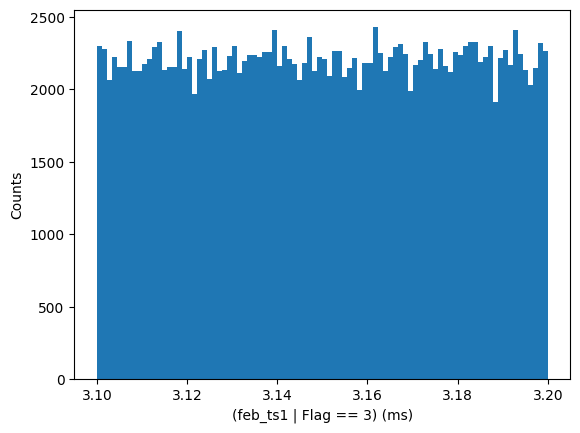

In [6]:
filter_ts0 = recodata["feb_ts0"][recodata.feb_flags == 3] 
filter_ts1 = recodata["feb_ts1"][recodata.feb_flags == 3]

plt.hist(ak.flatten(filter_ts1)/1e6, range=(3.1,3.2), bins = 90)
# plt.yscale('log')
plt.title('')
plt.ylabel('Counts')
plt.xlabel('(feb_ts1 | Flag == 3) (ms)')

In [7]:
def flag_map(flag_arr, flag = 11):
    return [1 if x == flag else 0 for x in flag_arr]

In [8]:
ts0_arr = recodata['feb_ts0']
ts1_arr = recodata['feb_ts1']

flags = recodata.feb_flags
tdc_time = recodata.tdc_timestamp
tdc_names = recodata.tdc_name

# Find the indices of 'etrig' in tdc_names
etrig_indices = ak.argmax(tdc_names == b'etrig', axis=1)

# Initialize an empty list to store the TDC etrig values
tdc_etrig = []

# Loop through each subarray in tdc_time and etrig_indices
for tdc_subarray, etrig_index in zip(tdc_time, etrig_indices):
	if etrig_index is not None:
		tdc_etrig.append(tdc_subarray[etrig_index])
	else:
		tdc_etrig.append(np.nan)  # Handle cases where etrig_index is None

# Convert the list to a numpy array
tdc_etrig = np.array(tdc_etrig)

# Get the last 9 digits for timing until t0 reset
tdc_offset = tdc_etrig % 1e9

# Calculate trig_time
trig_time = (ts0_arr - tdc_offset[:, None]) / 1e6  # convert from ns to ms

# Flatten the arrays and filter by flag
trig_time = ak.flatten(trig_time)
flag_arr = ak.flatten(flags)

trig_time = np.array(trig_time)
flag_arr = np.array(flag_arr)


In [9]:
flag_11 = flag_map(flag_arr, 11)
flag_3 = flag_map(flag_arr, 3)

### Flag counts vs time

Can see the a dead time of ~20 microseconds!

In [10]:
def plot_flag_deadtime(trig_time, flag_dict, title=None, bins=100, time_range=(-1.55, -1.5)):
    bin_edges = np.linspace(time_range[0], time_range[1], bins + 1)
    
    for flag, flag_arr in flag_dict.items():
        hist, _ = np.histogram(trig_time, bins=bin_edges, weights=flag_arr)
        plt.step(bin_edges[:-1], hist, where='mid', label=rf'Flag {flag}')
    
    plt.title(title)
    plt.xlabel('FEB TS0 - TDC ETRIG [ms]')
    plt.ylabel('Flag counts')
    plt.yscale('log')
    plt.legend()
    plt.show()

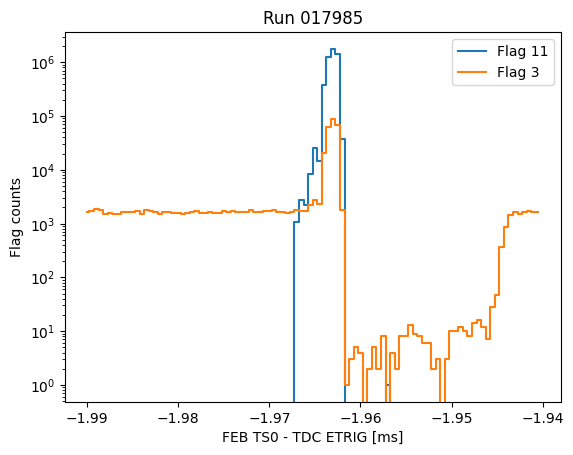

In [11]:
flag_dict = {11: flag_11, 3: flag_3}
time_range = (-1.99, -1.94) # time_range = (-3.2, -3.1)
plot_flag_deadtime(trig_time, flag_dict, title=f"Run {run}", time_range=time_range)

In [12]:
def save_as_pkl(trig_time, flag_11, flag_3, path, filename):
    data = {
        't0_etrig': trig_time,
        'flag_11': flag_11,
        'flag_3': flag_3
    }
    with open(os.path.join(path, filename), 'wb') as f:
        pkl.dump(data, f)

if save:
    # Saving this as a pkl to merge with the other data!
    path = "/exp/sbnd/data/users/jbateman/workdir/crt/run/"+run+"/"
    filename = f"flag_t0_etrig_{batch_number}.pkl"
    save_as_pkl(trig_time, flag_11, flag_3, path, filename)

### Top-hat plot

In [15]:
sp_features = ['cl_has_sp', 'cl_tagger', 'cl_sp_ts0', 'cl_sp_ts1', 'cl_sp_x', 'cl_sp_y', 'cl_sp_z'] # defining a reduced set of features to speed up processing

trk_features = ['tr_start_x', 'tr_start_y', 'tr_start_z', 'tr_end_x', 'tr_end_y', 'tr_end_z']

# Define a function to apply the boolean mask
def apply_mask(data, mask):
    return data[mask]

def calculate_rel_ts0(ts0, rwm, etrig):
    delta_t = etrig - rwm
    return (ts0 + delta_t)/1e3

# Apply the mask to each row
print("filtering dataframe")
mask = recodata['cl_has_sp']
filtered_df = {feature: apply_mask(recodata[feature], mask) for feature in sp_features}
print("tagger")

filtering dataframe
tagger


In [ ]:
# relative_ts0_vec = []
# relative_ts1_vec = []

filter_spx = []
filter_spy = []
filter_spz = []
filter_wall_tag = []

tagger_no_sp = filtered_df['cl_tagger']
sp_x = filtered_df['cl_sp_x']
sp_y = filtered_df['cl_sp_y']
sp_z = filtered_df['cl_sp_z']
sp_ts0 = filtered_df['cl_sp_ts0']
sp_ts1 = filtered_df['cl_sp_ts1']
tdc_time = recodata['tdc_timestamp']
tdc_names = recodata['tdc_name']

# Find the indices of 'crtt1', 'rwm', and 'etrig' in tdc_names
crtt1_indices = ak.argmax(tdc_names == b'crtt1', axis=1)
rwm_indices = ak.argmax(tdc_names == b'rwm', axis=1)
etrig_indices = ak.argmax(tdc_names == b'etrig', axis=1)

# # Filter out events with missing TDC data
valid_events = (crtt1_indices != -1) & (rwm_indices != -1) & (etrig_indices != -1)
# Apply the mask to filter valid events
tdc_names = tdc_names[valid_events]
tdc_time = tdc_time[valid_events]

# Extract the TDC values
tdc_crt = tdc_time[tdc_names == b'crtt1']
tdc_rwm = tdc_time[tdc_names == b'rwm']
tdc_etrig = tdc_time[tdc_names == b'etrig']

# Check that none of the entries in each array have length zero
filter = []
for crt, rwm, etrig in zip(tdc_crt, tdc_rwm, tdc_etrig):
    try:
        if len(crt) == 0 or len(rwm) == 0 or len(etrig) == 0:
            filter.extend([False])
        else:
            filter.extend([True])
    except:
        filter.extend([False])

sp_ts0 = sp_ts0[filter]
sp_ts1 = sp_ts1[filter]
sp_x = sp_x[filter]
sp_y = sp_y[filter]
sp_z = sp_z[filter]
tagger_no_sp = tagger_no_sp[filter]

tdc_etrig_flat = ak.flatten(tdc_etrig[filter]) % 1e12
tdc_rwm_flat = ak.flatten(tdc_rwm[filter]) % 1e12

# Calculate delta_t
delta_t = tdc_etrig_flat - tdc_rwm_flat


# Calculate relative timestamps
relative_ts0_vec = sp_ts0 + delta_t
relative_ts1_vec = sp_ts1 + delta_t

# Flatten the arrays
relative_ts0 = ak.flatten(relative_ts0_vec) / 1e3  # convert from ns to μs
relative_ts1 = ak.flatten(relative_ts1_vec) / 1e3  # convert from ns to μs
filter_spx = ak.flatten(sp_x)
filter_spy = ak.flatten(sp_y)
filter_spz = ak.flatten(sp_z)
filter_wall_tag = ak.flatten(tagger_no_sp)

# Convert to numpy arrays
relative_ts0 = np.array(relative_ts0)
relative_ts1 = np.array(relative_ts1)
filter_spx = np.array(filter_spx)
filter_spy = np.array(filter_spy)
filter_spz = np.array(filter_spz)
wall_tag = np.array(filter_wall_tag)

print(f"Skipped {len(recodata) - len(delta_t)} events due to missing TDC data")

Skipped 928 events due to missing TDC data


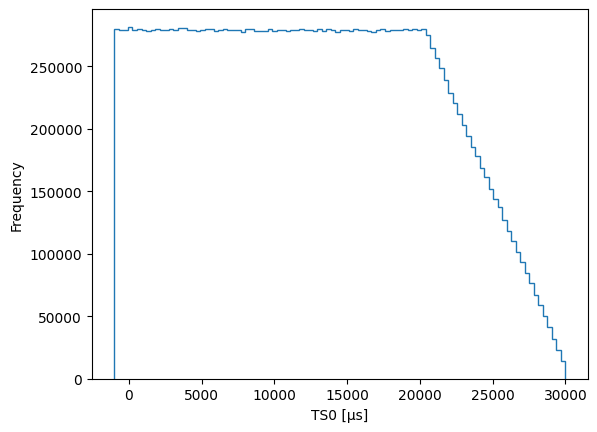

In [18]:
plt.hist(relative_ts0, bins=100, histtype='step', range=(-1000,30000))
plt.xlabel('TS0 [μs]')
plt.ylabel('Frequency')
plt.show()

In [19]:
def plot_sp_time(ts0, wall_tag, wall=None, title=None, bins=100, time_range = (-5,5), offset=1, log_scale=False, wall_names=CRT_Wall_Arr):

    if wall is not None:
        print('wall')
        if type(wall) in (list, np.ndarray):
            print('arr')
            for wall_number in wall:
                plt.hist(ts0[wall_tag==wall_number]+offset, histtype='step', bins=bins, range=time_range, label=wall_names[wall_number])
        elif type(wall) == int:
            print('int')
            plt.hist(ts0[wall_tag==wall]+offset, histtype='step', bins=bins, range=time_range, label=wall_names[wall])
        else:
            print("Invalid wall type, plotting all walls")
            plt.hist(ts0+offset, histtype='step', bins=bins, range=time_range)
        print('plotted')
    else:
        plt.hist(ts0+offset, histtype='step', bins=bins, range=time_range)


    plt.title(title)
    plt.xlabel(rf'CRT Space Point Time [$\mu s$]')
    plt.ylabel('Wall counts')
    if log_scale: 
        plt.yscale('log')
    plt.legend(title='Bin width = {:.3}μs'.format((time_range[1]-time_range[0])/bins))
    plt.show()

wall
arr
plotted


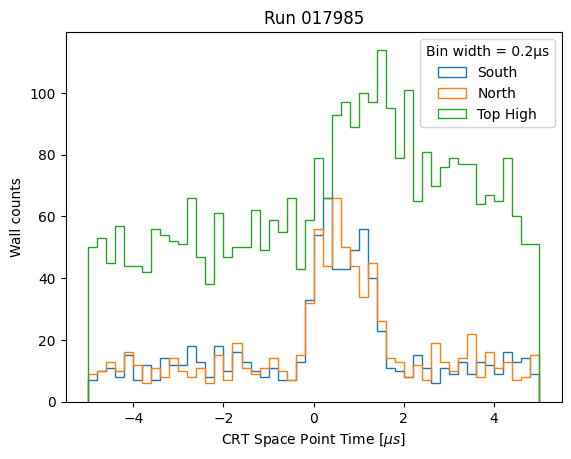

In [20]:
plot_sp_time(relative_ts0, wall_tag, wall=[1,2,6], title=f"Run {run}", bins=50)

Using the CRT spacepoint time, can I split the wall hits into two samples, in-window and out-of-window?

Then we can look at the spacepoints on the north/south walls and see if there is a concentration near to the centre of the beam! 

In [21]:
def plot_sp_coord_ratio(ts0, x, y, z, wall, run, plot_wall=1, interval_in = (-0.1, 1.7), interval_out = (-250, 250), offset=1, check_interval=False, bins=10, save=False):
    
    min_in, max_in = interval_in
    min_out, max_out = interval_out

    interval_in_window = (ts0 + offset > min_in) & (ts0 + offset < max_in) 
    interval_out_window = ((ts0 + offset < min_in) & (ts0 + offset > min_out)) | ((ts0 + offset > max_in) & (ts0 + offset < max_out))

    x_in = x[interval_in_window]
    y_in = y[interval_in_window]
    z_in = z[interval_in_window]

    wall_in = wall[interval_in_window]

    x_out = x[interval_out_window]
    y_out = y[interval_out_window]
    z_out = z[interval_out_window]

    wall_out = wall[interval_out_window]


    if check_interval:
        # Checking that we're splitting as we expect!
        # Slight overlap is due to binning
        time_range = (-5,5)
        bins_check = 50
        ts0_in = ts0[interval_in_window]
        ts0_out = ts0[interval_out_window]
        plt.hist(ts0_in + offset, histtype='step', bins=bins_check, range=time_range, label='In Window')
        plt.hist(ts0_out + offset, histtype='step', bins=bins_check, range=time_range, label='Out Window')
        plt.legend()
        plt.xlabel('CRT Space Point Time [μs]')
        plt.ylabel('Counts')
        plt.xlim(-5,5)
        plt.show()

    # North/South walls
    if plot_wall == 1 or plot_wall == 2:
        print('north/south')
        x_axis_in = x_in[wall_in == plot_wall]
        y_axis_in = y_in[wall_in == plot_wall]
        x_axis_out = x_out[wall_out == plot_wall]
        y_axis_out = y_out[wall_out == plot_wall]
        x_label = 'X [cm]'
        y_label = 'Y [cm]'

    # Bottom/top walls
    if plot_wall == 0 or plot_wall == 5 or plot_wall == 6:
        print('bottom/top')
        x_axis_in = z_in[wall_in == plot_wall]
        y_axis_in = x_in[wall_in == plot_wall]
        x_axis_out = z_out[wall_out == plot_wall]
        y_axis_out = x_out[wall_out == plot_wall]
        x_label = 'Z [cm]'
        y_label = 'X [cm]'

    # East/West walls
    if plot_wall == 3 or plot_wall == 4:
        print('east/west')
        x_axis_in = z_in[wall_in == plot_wall]
        y_axis_in = y_in[wall_in == plot_wall]
        x_axis_out = z_out[wall_out == plot_wall]
        y_axis_out = y_out[wall_out == plot_wall]
        x_label = 'Z [cm]'
        y_label = 'Y [cm]'
    
    hist_out, xedges, yedges = np.histogram2d(x_axis_out, y_axis_out, bins=bins)
    exposure_out = max_out - min_out - (max_in - min_in)
    hist_out = hist_out/exposure_out

    hist_in, xedges, yedges = np.histogram2d(x_axis_in, y_axis_in, bins=(xedges, yedges))
    exposure_in = max_in - min_in
    hist_in = hist_in/exposure_in
    
    ratio_hist = hist_in/hist_out

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    fig.suptitle(f'{CRT_Wall_Arr[plot_wall]} CRT Space Point Distribution (scaled by exposure time) - Run {run}')
    im1 = ax[0].imshow(hist_in.T, extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]], origin='lower', cmap='viridis')
    ax[0].set_title('In-Window ({} — {} μs)'.format(min_in, max_in))
    ax[0].set_xlabel(x_label)  
    ax[0].set_ylabel(y_label)

    im2 = ax[1].imshow(hist_out.T, extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]], origin='lower', cmap='viridis')
    ax[1].set_title('Out-of-Window ({} —  {} μs)'.format(min_out, max_out))
    ax[1].set_xlabel(x_label)
    ax[1].set_ylabel(y_label)

    # im3 = ax[2].imshow(ratio_hist.T, extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]], origin='lower', cmap='viridis')
    # ax[2].set_title('In/Out Ratio')
    # ax[2].set_xlabel(x_label)
    # ax[2].set_ylabel(y_label)

    im3 = ax[2].imshow((hist_in - hist_out).T, extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]], origin='lower', cmap='viridis')
    ax[2].set_title('Background Subtracted')
    ax[2].set_xlabel(x_label)
    ax[2].set_ylabel(y_label)


    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    fig.colorbar(im3, ax=ax[2])
    if save:
        # fig.save(rf'./figures/space_point_{CRT_Wall_Arr[plot_wall]}.png')
        plt.savefig(rf'./figures/space_point_{CRT_Wall_Arr[plot_wall]}.png')
    plt.show()


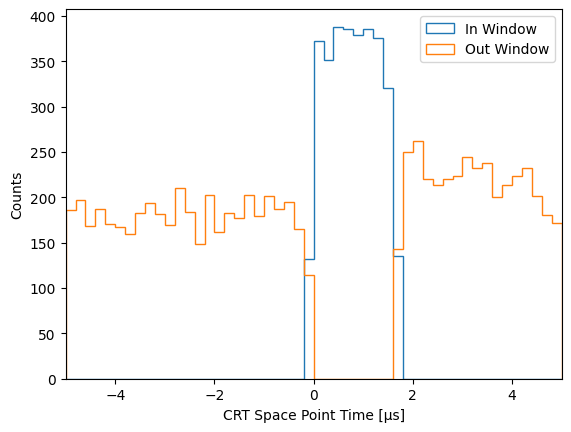

north/south


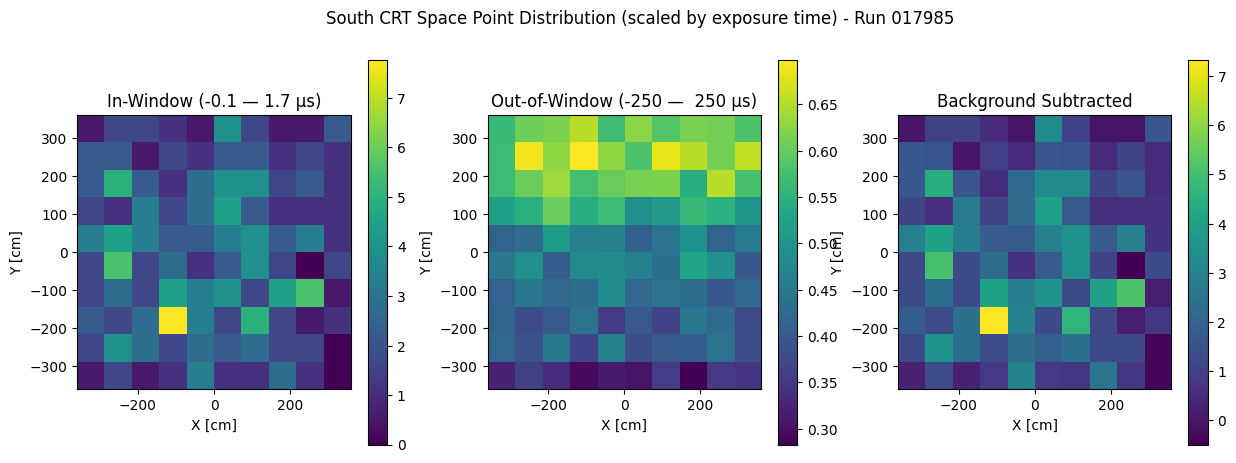

In [22]:
crt_offset = 1
plot_sp_coord_ratio(relative_ts0, filter_spx, filter_spy, filter_spz, wall_tag, run, plot_wall=1, interval_in=(-0.1, 1.7), interval_out=(-250, 250), offset=crt_offset, check_interval=True, bins=10)

1
north/south


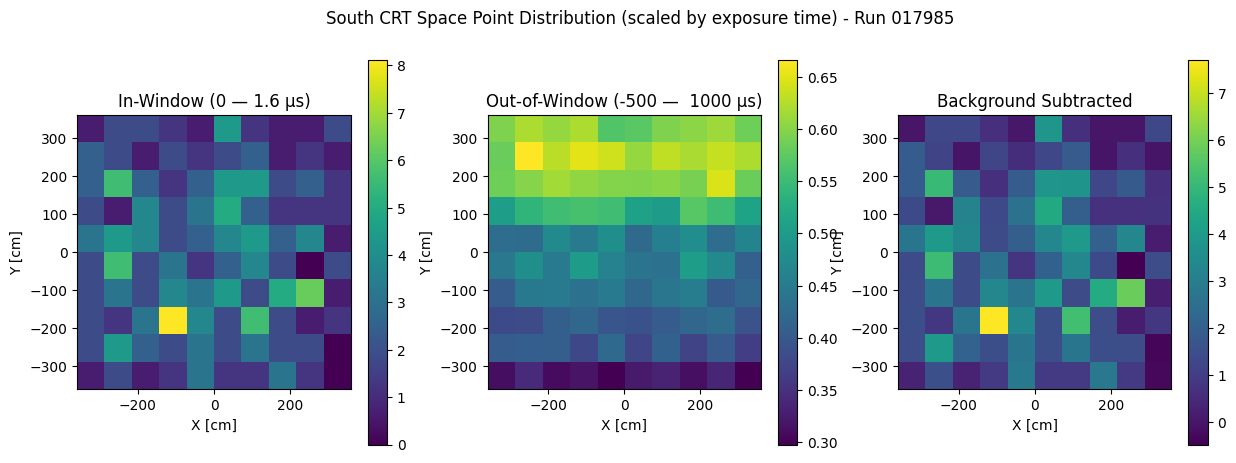

2
north/south


/tmp/ipykernel_178360/249549417.py:75: RuntimeWarning: invalid value encountered in divide
  ratio_hist = hist_in/hist_out


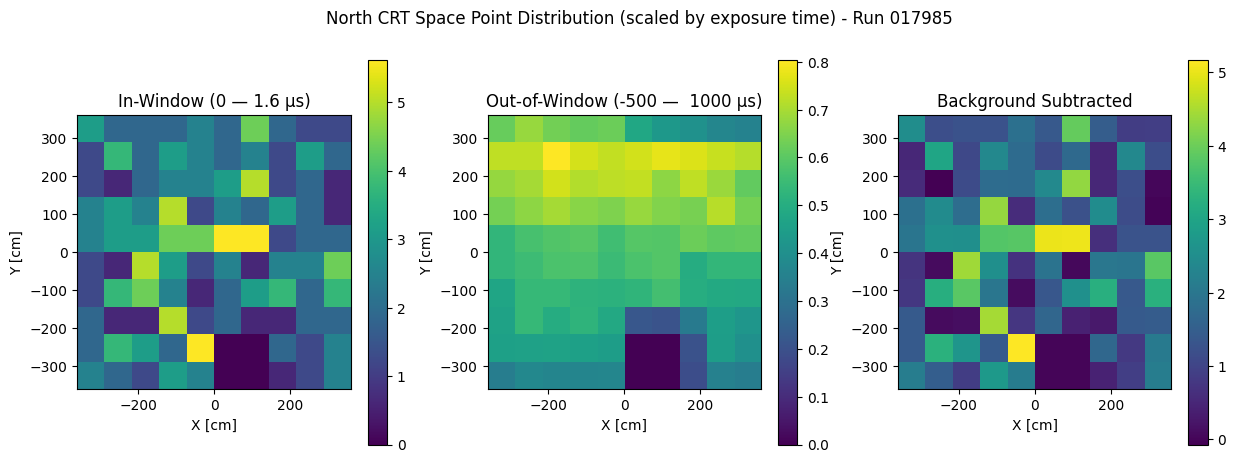

3
east/west


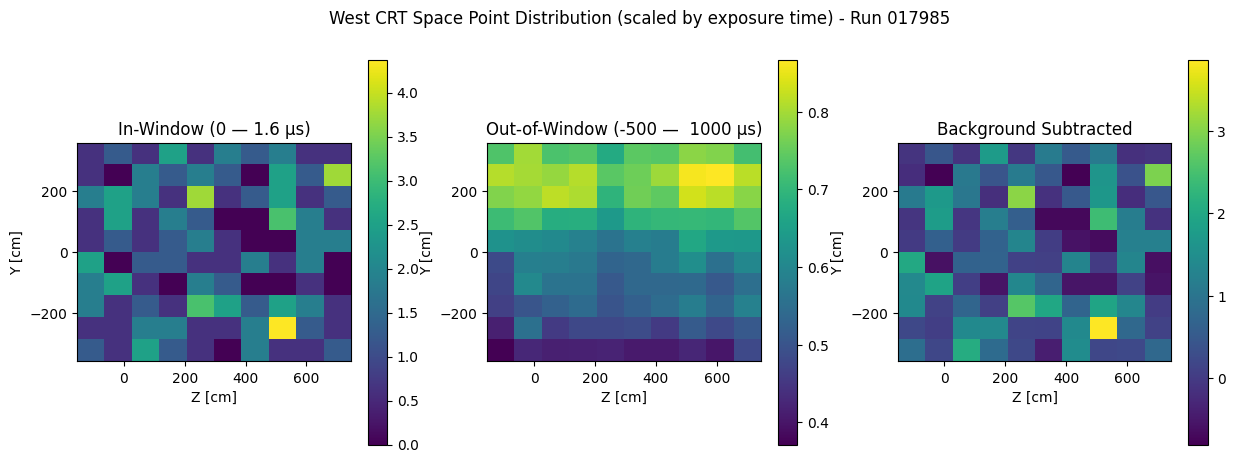

4
east/west


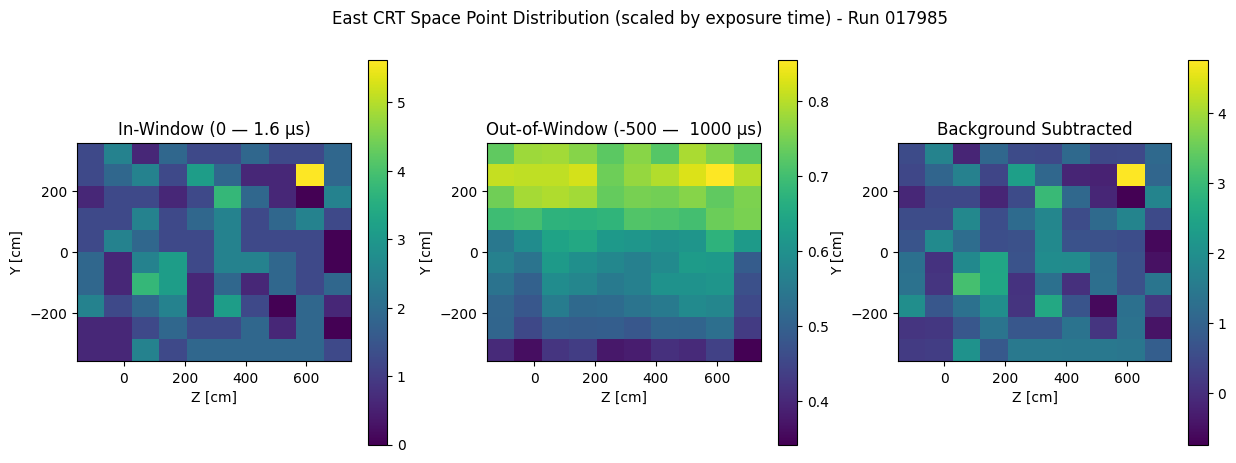

0
bottom/top


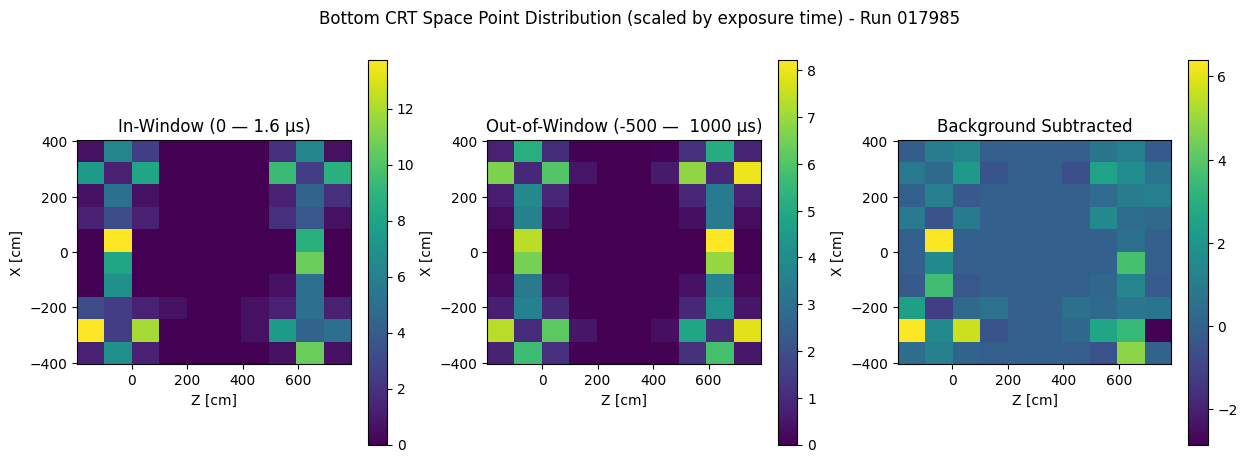

5
bottom/top


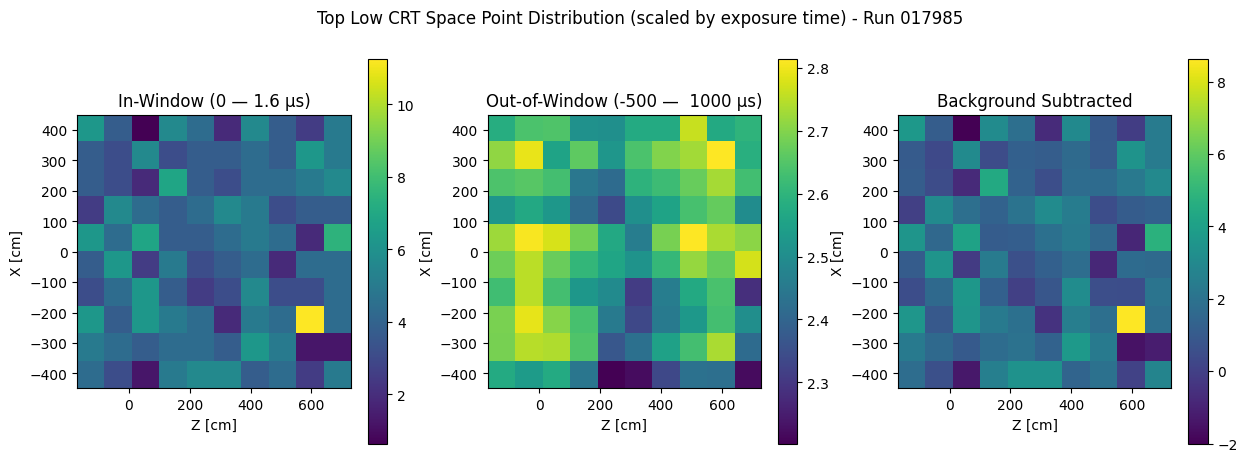

6
bottom/top


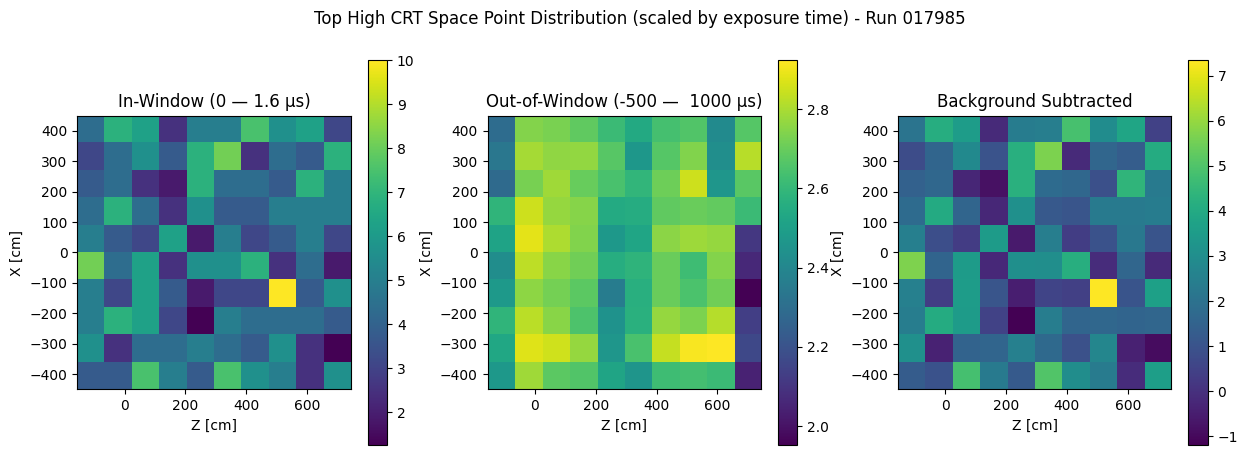

In [23]:
for wall_id in (list(CRT_Wall_Dict.values())):
    print(wall_id)
    plot_sp_coord_ratio(relative_ts0, filter_spx, filter_spy, filter_spz, wall_tag, run, plot_wall=wall_id, interval_in=(0, 1.6), interval_out=(-500, 1000), check_interval=False, bins=10, save=True)

In [273]:
def save_as_pkl(relative_ts0, wall_tag, filter_spx, filter_spy, filter_spz, path, filename):
    data = {
        'relative_ts0': relative_ts0,
        'wall_tag': wall_tag,
        'filter_spx': filter_spx,
        'filter_spy': filter_spy,
        'filter_spz': filter_spz
    }
    with open(os.path.join(path, filename), 'wb') as f:
        pkl.dump(data, f)

if save:
    # Saving this to a pkl to combine with other runs
    path = "/exp/sbnd/data/users/jbateman/workdir/crt/run/"+run+"/"
    filename = f"sp_timing_{batch_number}.pkl"
    save_as_pkl(relative_ts0, wall_tag, filter_spx, filter_spy, filter_spz, path, filename)

## Matching Top CRT Hits per Spill

To begin, we use the same processing as before, but don't flatten the arrays

In [206]:

filter_spx = []
filter_spy = []
filter_spz = []
filter_wall_tag = []

tagger_no_sp = filtered_df['cl_tagger']
sp_x = filtered_df['cl_sp_x']
sp_y = filtered_df['cl_sp_y']
sp_z = filtered_df['cl_sp_z']
sp_ts0 = filtered_df['cl_sp_ts0']
sp_ts1 = filtered_df['cl_sp_ts1']
tdc_time = recodata['tdc_timestamp']
tdc_names = recodata['tdc_name']

# Find the indices of 'crtt1', 'rwm', and 'etrig' in tdc_names
crtt1_indices = ak.argmax(tdc_names == b'crtt1', axis=1)
rwm_indices = ak.argmax(tdc_names == b'rwm', axis=1)
etrig_indices = ak.argmax(tdc_names == b'etrig', axis=1)

# # Filter out events with missing TDC data
valid_events = (crtt1_indices != -1) & (rwm_indices != -1) & (etrig_indices != -1)
# Apply the mask to filter valid events
tdc_names = tdc_names[valid_events]
tdc_time = tdc_time[valid_events]

# Extract the TDC values
tdc_crt = tdc_time[tdc_names == b'crtt1']
tdc_rwm = tdc_time[tdc_names == b'rwm']
tdc_etrig = tdc_time[tdc_names == b'etrig']

# Check that none of the entries in each array have length zero
filter = []
for crt, rwm, etrig in zip(tdc_crt, tdc_rwm, tdc_etrig):
    try:
        if len(crt) == 0 or len(rwm) == 0 or len(etrig) == 0:
            filter.extend([False])
        else:
            filter.extend([True])
    except:
        filter.extend([False])

sp_ts0 = sp_ts0[filter]
sp_ts1 = sp_ts1[filter]
sp_x = sp_x[filter]
sp_y = sp_y[filter]
sp_z = sp_z[filter]
tagger_no_sp = tagger_no_sp[filter] # This is the wall tag

tdc_etrig_flat = ak.flatten(tdc_etrig[filter]) % 1e12
tdc_rwm_flat = ak.flatten(tdc_rwm[filter]) % 1e12

# Calculate delta_t
delta_t = tdc_etrig_flat - tdc_rwm_flat


# Calculate relative timestamps
relative_ts0_vec = sp_ts0 + delta_t
relative_ts1_vec = sp_ts1 + delta_t

In [207]:
# Select only events from the top walls
top_lo_index = 5
top_hi_index = 6
# Use tdc_rwm to match events
rwm_stamp = ak.flatten(tdc_rwm[filter]) 

lo_filter = tagger_no_sp == top_lo_index
hi_filter = tagger_no_sp == top_hi_index
# If vec contains one true entry, return true
lo_result = [np.any(vec) for vec in lo_filter]
hi_result = [np.any(vec) for vec in hi_filter]

lo_ts0 = relative_ts0_vec[tagger_no_sp == top_lo_index]
lo_ts1 = relative_ts1_vec[tagger_no_sp == top_lo_index]
lo_x = sp_x[tagger_no_sp == top_lo_index]
lo_y = sp_y[tagger_no_sp == top_lo_index]
lo_z = sp_z[tagger_no_sp == top_lo_index]
lo_rwm = rwm_stamp[lo_result]

hi_ts0 = relative_ts0_vec[tagger_no_sp == top_hi_index]
hi_ts1 = relative_ts1_vec[tagger_no_sp == top_hi_index]
hi_x = sp_x[tagger_no_sp == top_hi_index]
hi_y = sp_y[tagger_no_sp == top_hi_index]
hi_z = sp_z[tagger_no_sp == top_hi_index]
hi_rwm = rwm_stamp[hi_result]


In [208]:
# Filter to select events in the beam window
lo_ts0_filter = ((lo_ts0/1e3 + 1 < 0) & (lo_ts0/1e3 + 1 > -500)) | ((lo_ts0/1e3 + 1 > 1.6) & (lo_ts0/1e3 + 1 < 500))
lo_ts0_result = [np.any(vec) for vec in lo_ts0_filter]

lo_ts0 = lo_ts0[lo_ts0_filter][lo_ts0_result]
lo_ts1 = lo_ts1[lo_ts0_filter][lo_ts0_result]
lo_x = lo_x[lo_ts0_filter][lo_ts0_result]
lo_y = lo_y[lo_ts0_filter][lo_ts0_result]
lo_z = lo_z[lo_ts0_filter][lo_ts0_result]
lo_rwm = lo_rwm[lo_ts0_result]

hi_ts0_filter = (hi_ts0/1e3 + 1 > 0) & (hi_ts0/1e3 + 1 < 1.6)
hi_ts0_result = [np.any(vec) for vec in hi_ts0_filter]

hi_ts0 = hi_ts0[hi_ts0_filter][hi_ts0_result]
hi_ts1 = hi_ts1[hi_ts0_filter][hi_ts0_result]
hi_x = hi_x[hi_ts0_filter][hi_ts0_result]
hi_y = hi_y[hi_ts0_filter][hi_ts0_result]
hi_z = hi_z[hi_ts0_filter][hi_ts0_result]
hi_rwm = hi_rwm[hi_ts0_result]

In [209]:
# Checking we actually have some events!
# print(len(np.unique(ak.flatten(lo_ts0))), len(np.unique(ak.flatten(hi_ts0))))
# These should be the same or less than previous print
# print(len(lo_rwm), len(hi_rwm))

def match_rwm_tags(lo, hi):

    lo_index_arr, hi_index_arr = [], []

    for lo_index, lo_rwm in enumerate(lo):
        for hi_index, hi_rwm in enumerate(hi):
            if lo_rwm == hi_rwm:
                lo_index_arr.append(lo_index)
                hi_index_arr.append(hi_index)

    return lo_index_arr, hi_index_arr

index_lo, index_hi = match_rwm_tags(lo_rwm, hi_rwm)

lo_ts0 = lo_ts0[index_lo]
lo_ts1 = lo_ts1[index_lo]
lo_x = lo_x[index_lo]
lo_y = lo_y[index_lo]
lo_z = lo_z[index_lo]

hi_ts0 = hi_ts0[index_hi]
hi_ts1 = hi_ts1[index_hi]
hi_x = hi_x[index_hi]
hi_y = hi_y[index_hi]
hi_z = hi_z[index_hi]


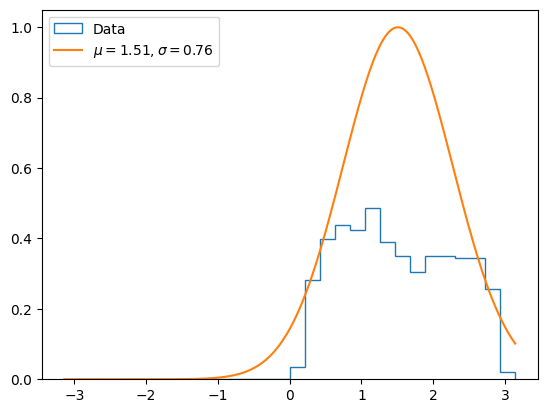

In [210]:
def vector_lo_hi(lo_xyz, hi_xyz):

    lo_x, lo_y, lo_z = lo_xyz
    hi_x, hi_y, hi_z = hi_xyz

    return hi_x - lo_x, hi_y - lo_y, hi_z - lo_z
# Assume there is only one entry in each array
dx, dy, dz = vector_lo_hi([lo_x[:,0], lo_y[:,0], lo_z[:,0]], [hi_x[:,0], hi_y[:,0], hi_z[:,0]])

hit_vector = np.transpose([dx, dy, dz])

def vec_angle(vector, ref_vector=[0,0,1]):
    # bnb_vec = [0,0,1]

    dot_product = np.dot(vector, ref_vector)
    mag_bnb = np.linalg.norm(ref_vector)
    mag_vec = np.linalg.norm(vector, axis=1)

    cos_theta = dot_product/(mag_bnb*mag_vec)
    return cos_theta

bnb_vector = [0,0,1]
down_vector  = [0, 1, 0]

angles = np.arccos(vec_angle(hit_vector, bnb_vector))
mean, std = np.mean(angles), np.std(angles)

def gauss(x, H, A, x0, sigma): 
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

x_range = np.linspace(-np.pi, np.pi, 1000)
y_range = gauss(x_range, 0, 1, mean, std)


plt.hist(angles, bins=30, range=(-np.pi, np.pi), histtype='step', label='Data', density=True)
plt.plot(x_range, y_range, label=rf'$\mu = {mean:.2f}, \sigma = {std:.2f}$')
plt.legend()
plt.show()

Mean angle is perpendicular to beam axis, ie pointing straight down

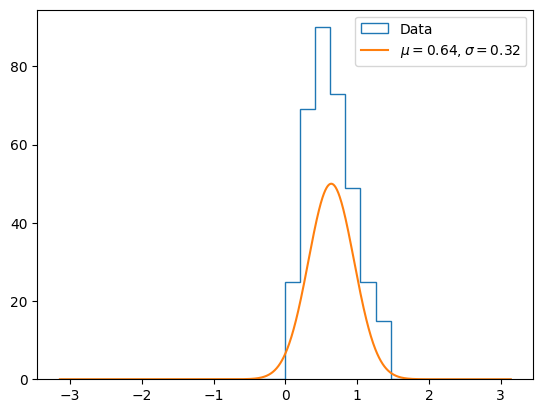

In [179]:
angles = np.arccos(vec_angle(hit_vector, down_vector))
mean, std = np.mean(angles), np.std(angles)

def gauss(x, H, A, x0, sigma): 
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

x_range = np.linspace(-np.pi, np.pi, 1000)
y_range = gauss(x_range, 0, 50, mean, std)


plt.hist(angles, bins=30, range=(-np.pi, np.pi), histtype='step', label='Data')
plt.plot(x_range, y_range, label=rf'$\mu = {mean:.2f}, \sigma = {std:.2f}$')
plt.legend()
plt.show()

# Combined run figures
For a list of runs that have been process above, the output csv files are loaded, merged and the combined figures are plotted

In [274]:
list_of_runs = [13688, 13689, 13690, 13693, 13758]
path = "/exp/sbnd/data/users/jbateman/workdir/crt/run/"
    # run="013688"
    # folder_path = path+run
n_batches = []

# December runs
list_of_runs = [17987]# [17985, 17987]
batch_size = 5
filename = "crt_ana_*" 

# path = "/exp/sbnd/data/users/jbateman/workdir/crt/run/"
path = "/pnfs/sbnd/persistent/users/jbateman/crt/run/"
n_batches = []

filename = "crt_ana_*" # "crtana_data_*"

for run in list_of_runs:

    folder_path = path + "0" + str(run) + "/"
    matching_files = list_matching_files(folder_path,filename)
    n_batches.append(int(np.ceil(len(matching_files)/batch_size)))


In [30]:
path = "/exp/sbnd/data/users/jbateman/workdir/crt/run/"
filename_deadtime = 'flag_t0_etrig_' # 'flag_t0_etrig.pkl'
filename_sp = 'sp_timing_'

arr_flag_t0_etrig = np.empty((0, 3))
arr_sp_timing = np.empty((0, 5))

for i, run in enumerate(list_of_runs):
    for batch in range(n_batches[i]):
        batch_deadtime = filename_deadtime + str(batch) + '.pkl'
        batch_sp = filename_sp + str(batch) + '.pkl'
        
        with open(path + "0" + str(run) + "/" + batch_deadtime, 'rb') as f:
            data_deadtime = pkl.load(f)
            arr_flag_t0_etrig = np.vstack([arr_flag_t0_etrig, np.column_stack((data_deadtime['t0_etrig'], data_deadtime['flag_11'], data_deadtime['flag_3']))])
        
        with open(path + "0" + str(run) + "/" + batch_sp, 'rb') as f:
            data_sp = pkl.load(f)
            arr_sp_timing = np.vstack([arr_sp_timing, np.column_stack((data_sp['relative_ts0'], data_sp['wall_tag'], data_sp['filter_spx'], data_sp['filter_spy'], data_sp['filter_spz']))])

ts0_etrig = arr_flag_t0_etrig[:, 0]
flag_11 = arr_flag_t0_etrig[:, 1]
flag_3 = arr_flag_t0_etrig[:, 2]

ts0_rwm = arr_sp_timing[:, 0]
wall = arr_sp_timing[:, 1]
spx = arr_sp_timing[:, 2]
spy = arr_sp_timing[:, 3]
spz = arr_sp_timing[:, 4]

In [31]:
ts0_etrig = arr_flag_t0_etrig[:, 0]
flag_11 = arr_flag_t0_etrig[:, 1]
flag_3 = arr_flag_t0_etrig[:, 2]

ts0_rwm = arr_sp_timing[:, 0]
wall = arr_sp_timing[:, 1]
spx = arr_sp_timing[:, 2]
spy = arr_sp_timing[:, 3]
spz = arr_sp_timing[:, 4]

## Dead time

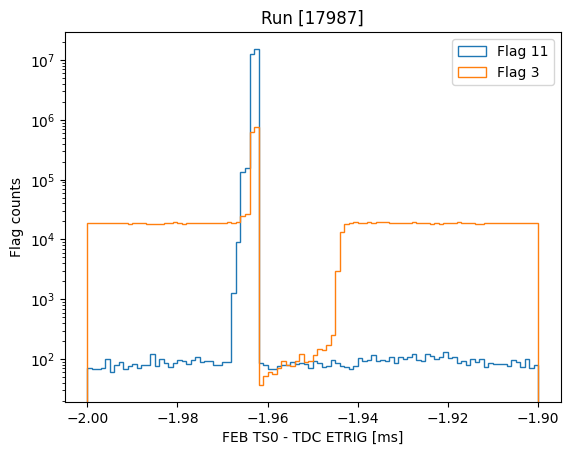

In [32]:
time_range = (-2,-1.9)
plot_flag_deadtime(ts0_etrig, {11: flag_11, 3: flag_3}, title=f"Run {list_of_runs}", time_range=time_range)


## Top-hat

/tmp/ipykernel_3763793/2565711467.py:25: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



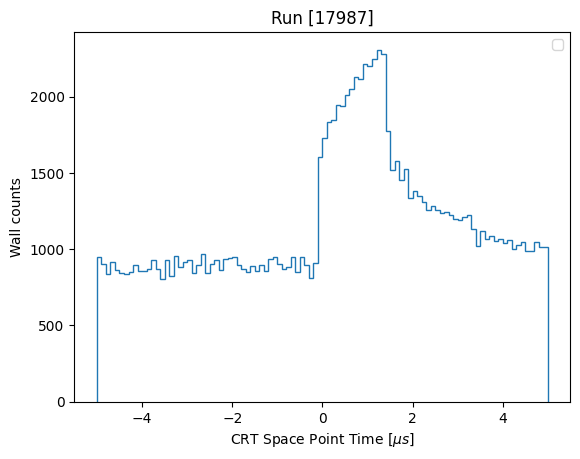

In [33]:
plot_sp_time(ts0_rwm, wall, title=f"Run {list_of_runs}", bins=100)

wall
arr
plotted


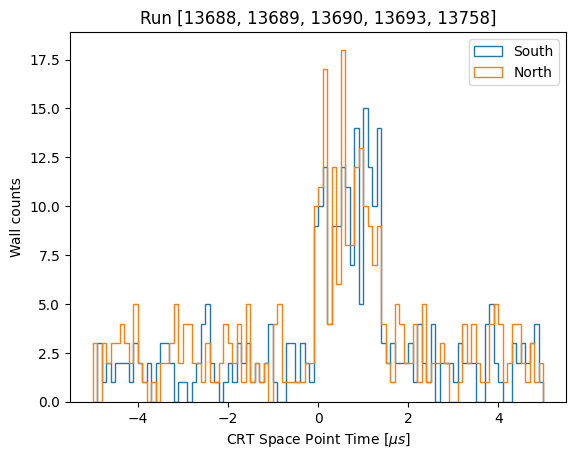

In [70]:
plot_sp_time(ts0_rwm, wall, wall=[1,2], title=f"Run {list_of_runs}", bins=100)

## Space-point distribution

1
north/south


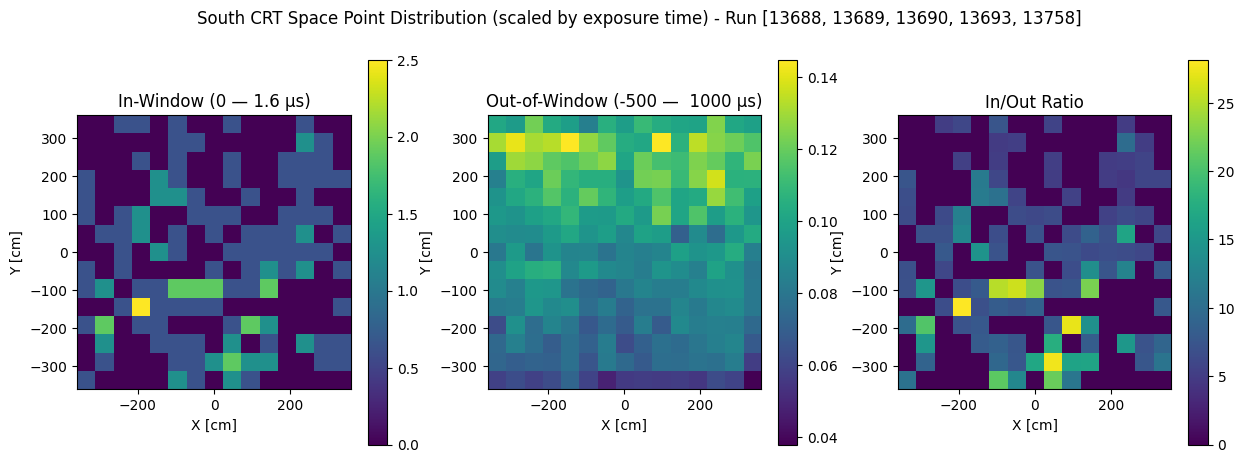

2
north/south


/tmp/ipykernel_811665/2378616401.py:74: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_811665/2378616401.py:74: RuntimeWarning:

invalid value encountered in divide



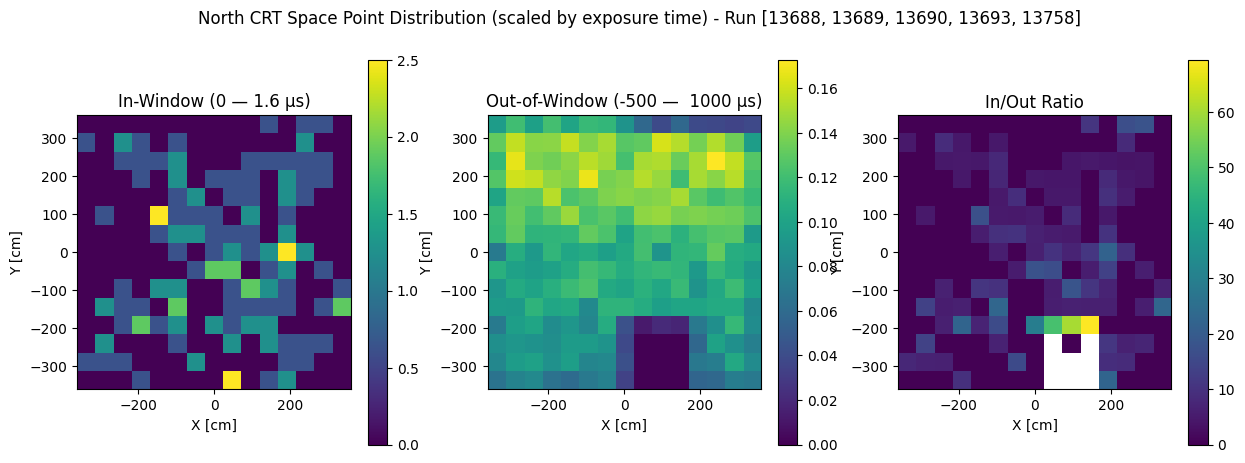

3
east/west


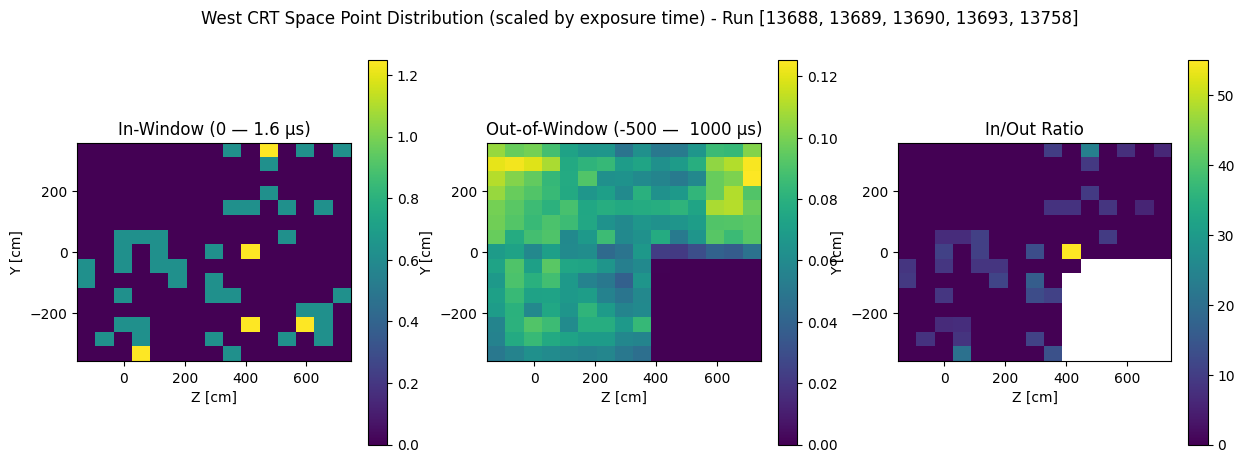

4
east/west


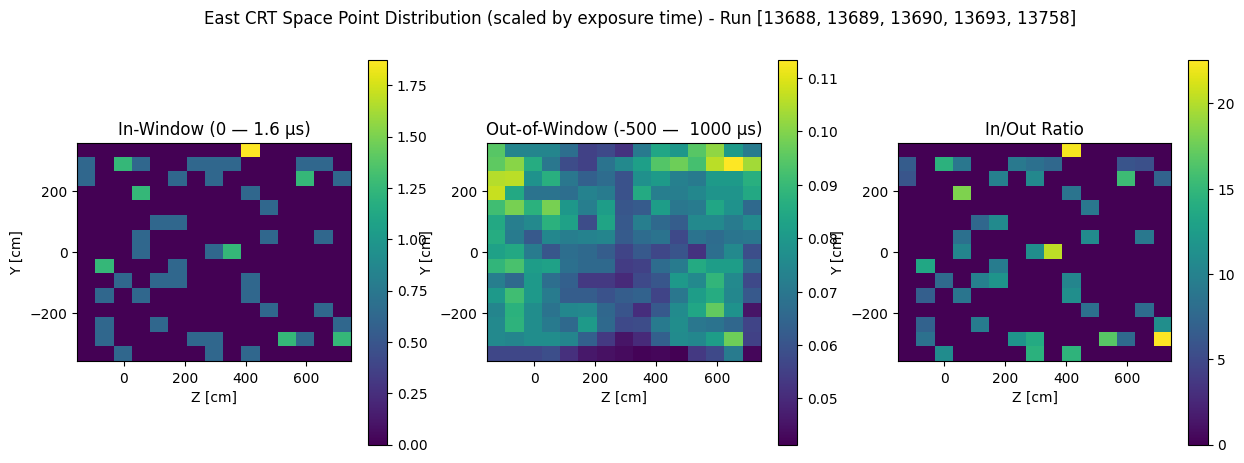

0
bottom/top


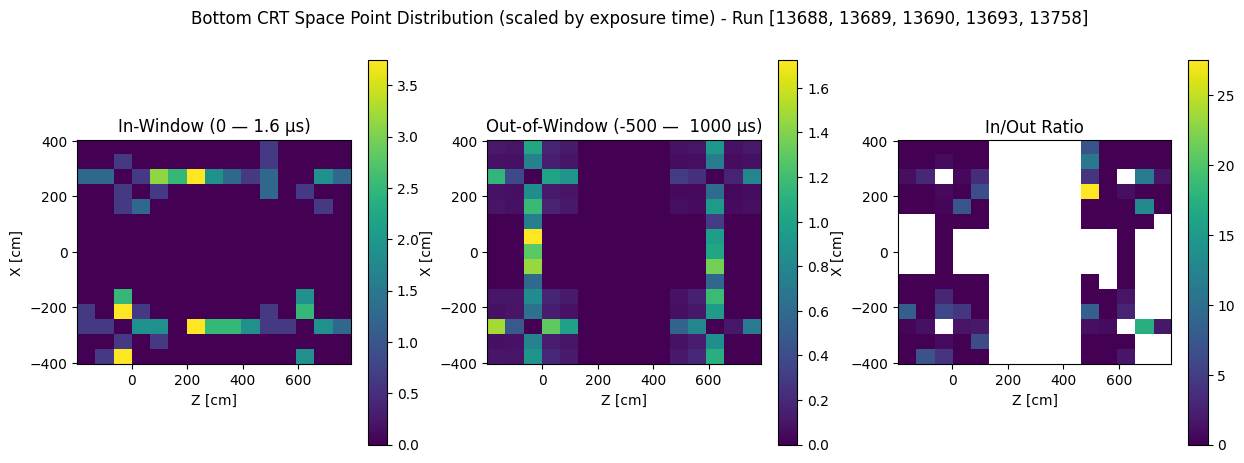

5
bottom/top


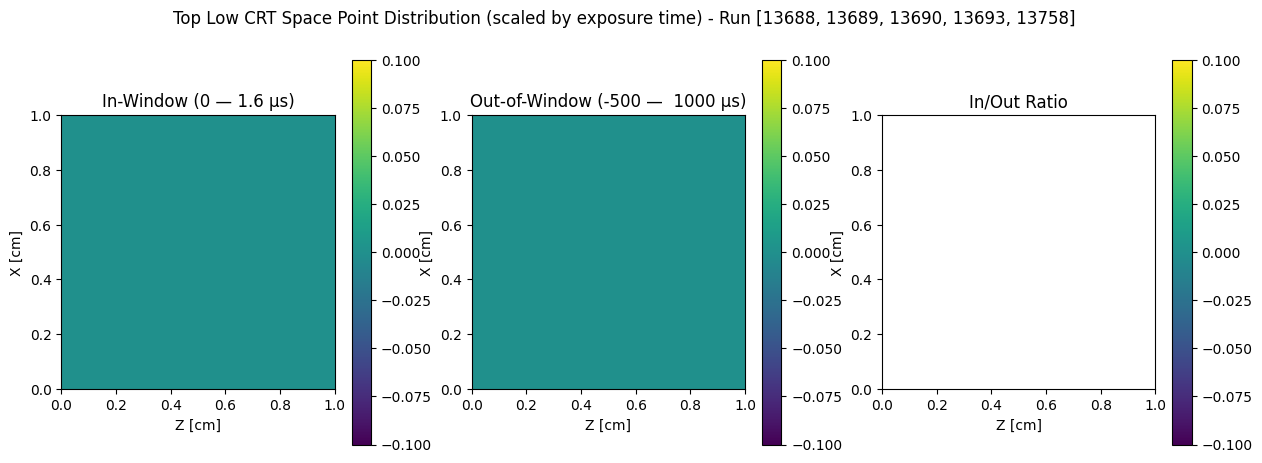

6
bottom/top


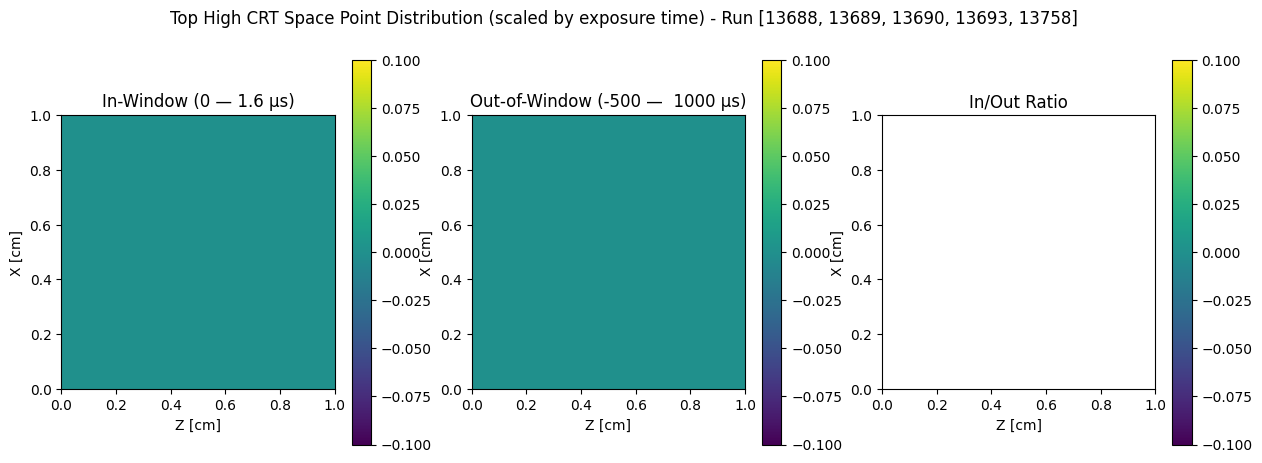

In [71]:
for wall_id in (list(CRT_Wall_Dict.values())):
    print(wall_id)
    plot_sp_coord_ratio(ts0_rwm, spx, spy, spz, wall, list_of_runs, plot_wall=wall_id, interval_in=(0, 1.6), interval_out=(-500, 1000), check_interval=False, bins=15, save=True)